# **Probing accuracy**

In [1]:
import json
import pandas as pd
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
def plot_model_accuracy(records, images_dir, model_name, dataset_name="triviaqa"):
    """
    Plots the model accuracy from the metrics file and saves the plot as an image.
    
    Args:
        metrics_dir (str): Directory containing the metrics files.
        images_dir (str): Directory to save the plot images.
        model_name (str): Name of the LLM.
        dataset_name (str): Name of the dataset.
    """
    model_name = model_name.split("/")[-1]
    # Replace "fully_connected" with "mlp" in the activation column for plotting
    records = records.copy()
    records["activation"] = records["activation"].replace("fully_connected", "mlp")

    palette = {"mlp": "blue", "attention": "green"}

    image_save_dir = os.path.join(images_dir, "hallucination_detection")
    os.makedirs(image_save_dir, exist_ok=True)

    rcParams['axes.labelsize'] = 21
    rcParams['xtick.labelsize'] = 15
    rcParams['ytick.labelsize'] = 15
    rcParams['legend.fontsize'] = 22
    rcParams['legend.title_fontsize'] = 20
    rcParams.update({
        'font.family': 'serif',
        'text.usetex': False,
        'mathtext.default': 'regular',
        'font.weight': 'bold',
    })

    plt.figure(figsize=(12, 8), dpi=150)
    sns.lineplot(data=records, x="layer", y="ACC", hue="activation", palette=palette)
    # plt.title(f"Probing model for conflict classification. Accuracy\n{model_name} {data_name}")
    plt.ylabel("Accuracy")
    plt.xlabel("Layer")
    plt.grid(True)
    plt.savefig(os.path.join(image_save_dir, f"{model_name} {dataset_name} Accuracy.pdf"), format='pdf', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(12, 8), dpi=150)
    sns.lineplot(data=records, x="layer", y="AUC", hue="activation", palette=palette)
    plt.ylabel("AUROC")
    plt.xlabel("Layer")
    plt.grid(True)
    plt.legend(loc="lower right", title="activation")
    plt.savefig(os.path.join(image_save_dir, f"{model_name} {dataset_name} AUROC.pdf"), format='pdf', bbox_inches='tight')
    plt.show()


In [3]:
def to_df(data):
    # Prepare list for rows
    rows = []

    # Iterate over the JSON items
    for key, value in data.items():
        if "logits" in key:
            continue  # Skip logits

        match = re.match(r"first_(\w+?)_(roc|acc)_(\d+)", key)
        if match:
            activation, metric, layer = match.groups()
            layer = int(layer)

            # Ensure there's a row for each layer/activation
            while len(rows) <= layer or not any(r['layer'] == layer and r['activation'] == activation for r in rows):
                rows.append({'layer': layer, 'activation': activation, 'ACC': None, 'AUC': None})

            # Update the appropriate row
            for r in rows:
                if r['layer'] == layer and r['activation'] == activation:
                    r['AUC' if metric == 'roc' else 'ACC'] = value

    # Create DataFrame
    df = pd.DataFrame(rows)
    df = df.sort_values(by=['activation', 'layer']).reset_index(drop=True)

    return df

## **Original setting**

In [4]:
# Load JSON data from a file
with open("metrics.json", "r") as f:
    data = json.load(f)

df = to_df(data)

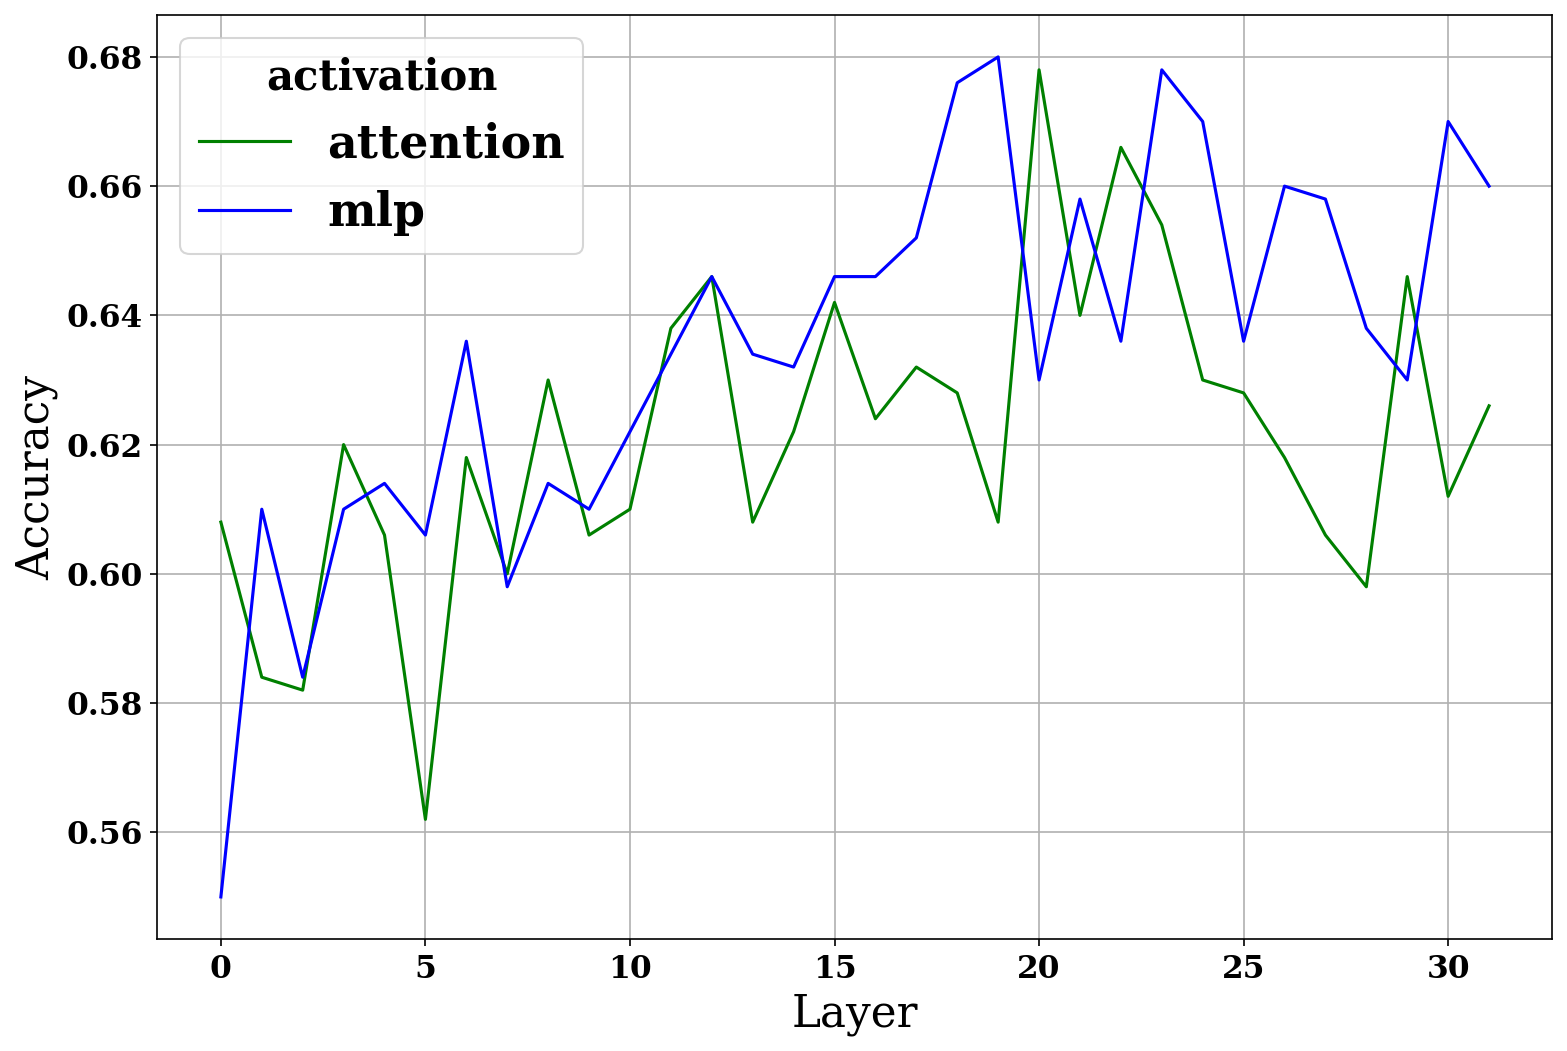

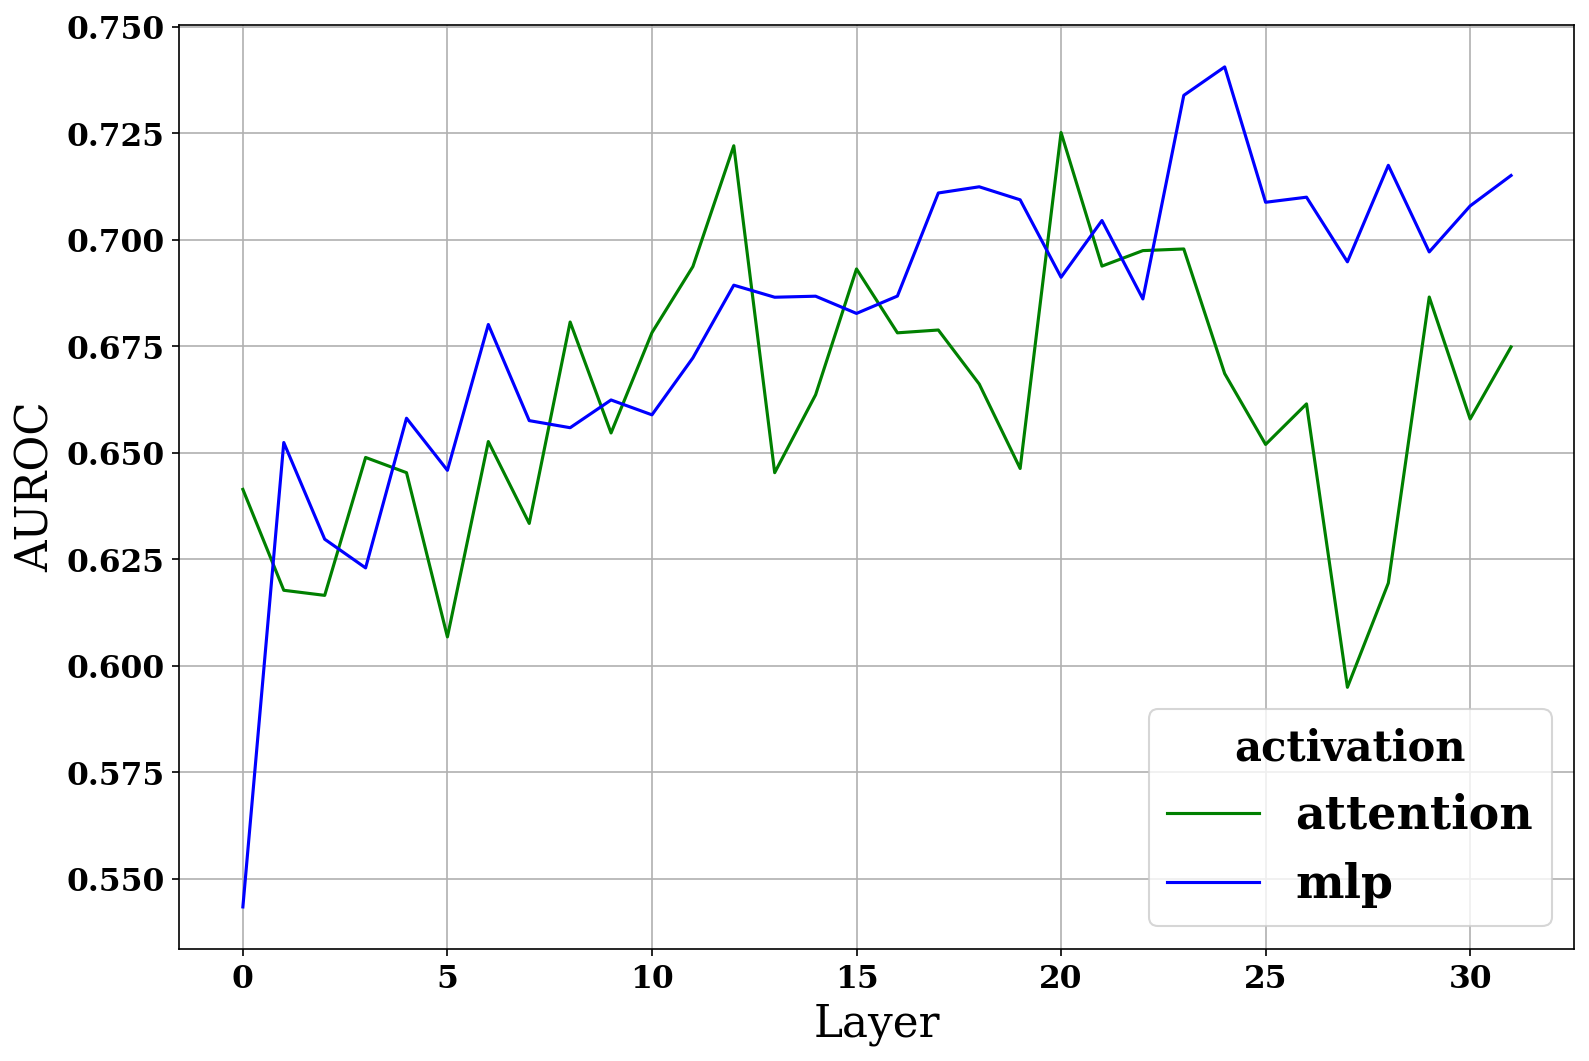

In [5]:
plot_model_accuracy(df, "images", "falcon-7b", "triviaqa")

## **Knowledge Conflict**

In [6]:
# Load and merge json the 2 metric files
mlp_logits_file = "logits_fully_connected_kc_metrics.json"
attention_logits_file = "attention_kc_metrics.json"

with open(mlp_logits_file, "r") as f:
    mlp_data = json.load(f)

with open(attention_logits_file, "r") as f:
    attention_data = json.load(f)

# Merge the two json files
merged_data = {**mlp_data, **attention_data}

In [7]:
kc_df = to_df(merged_data)

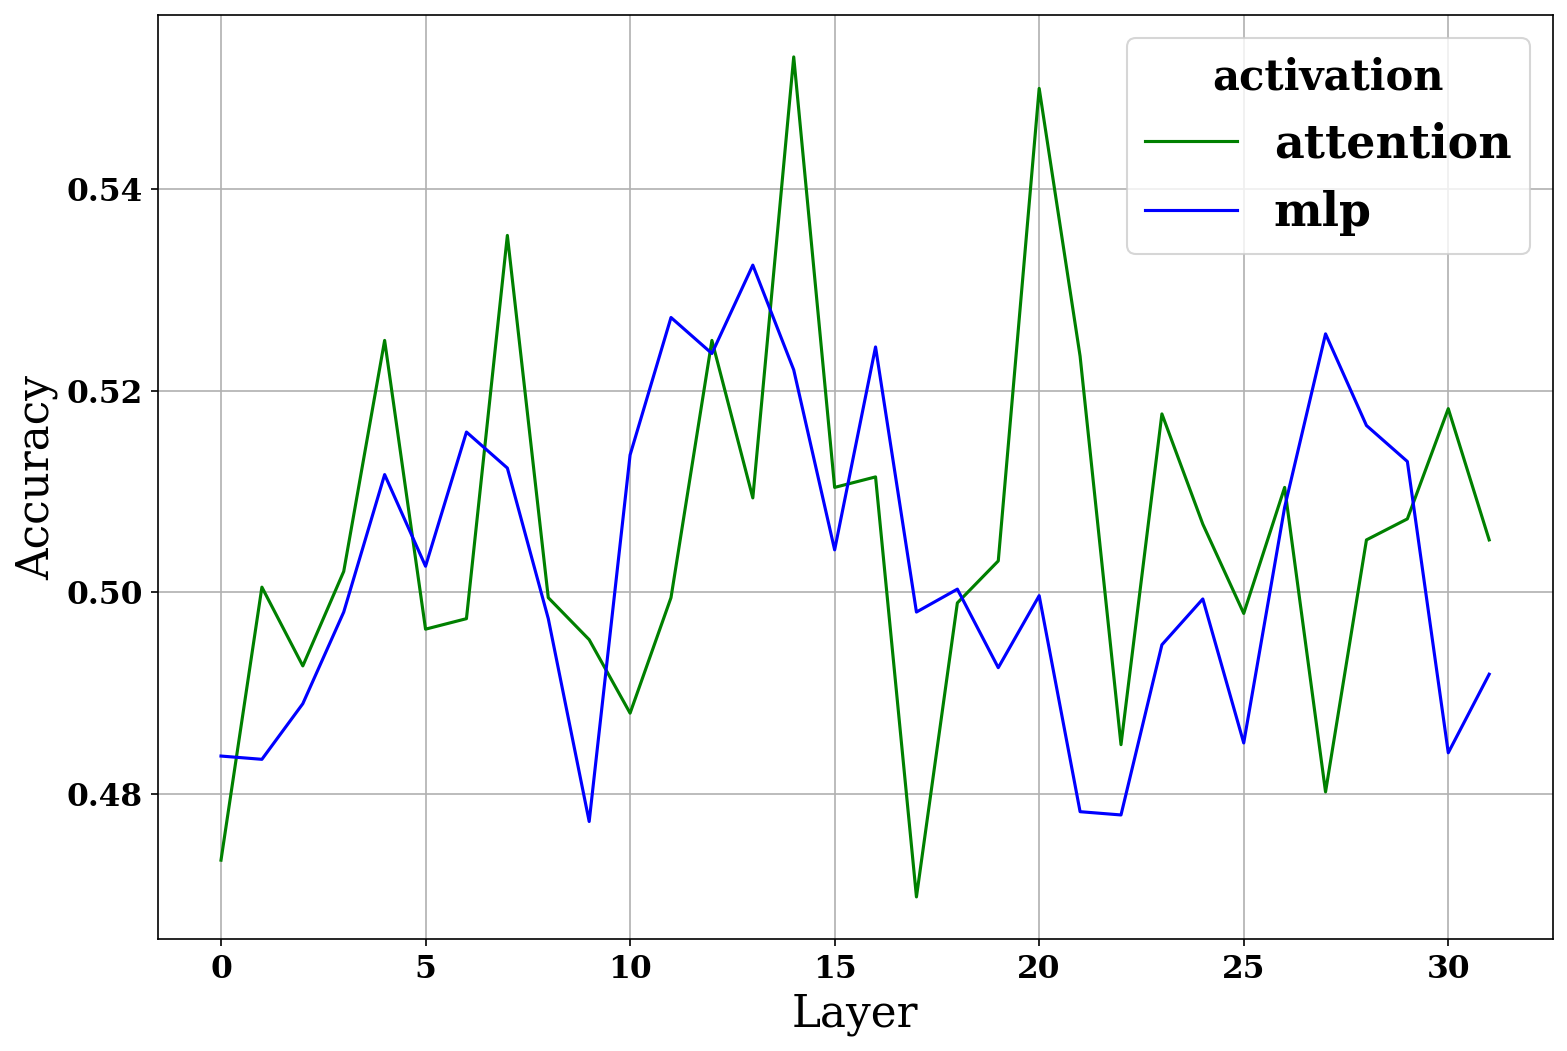

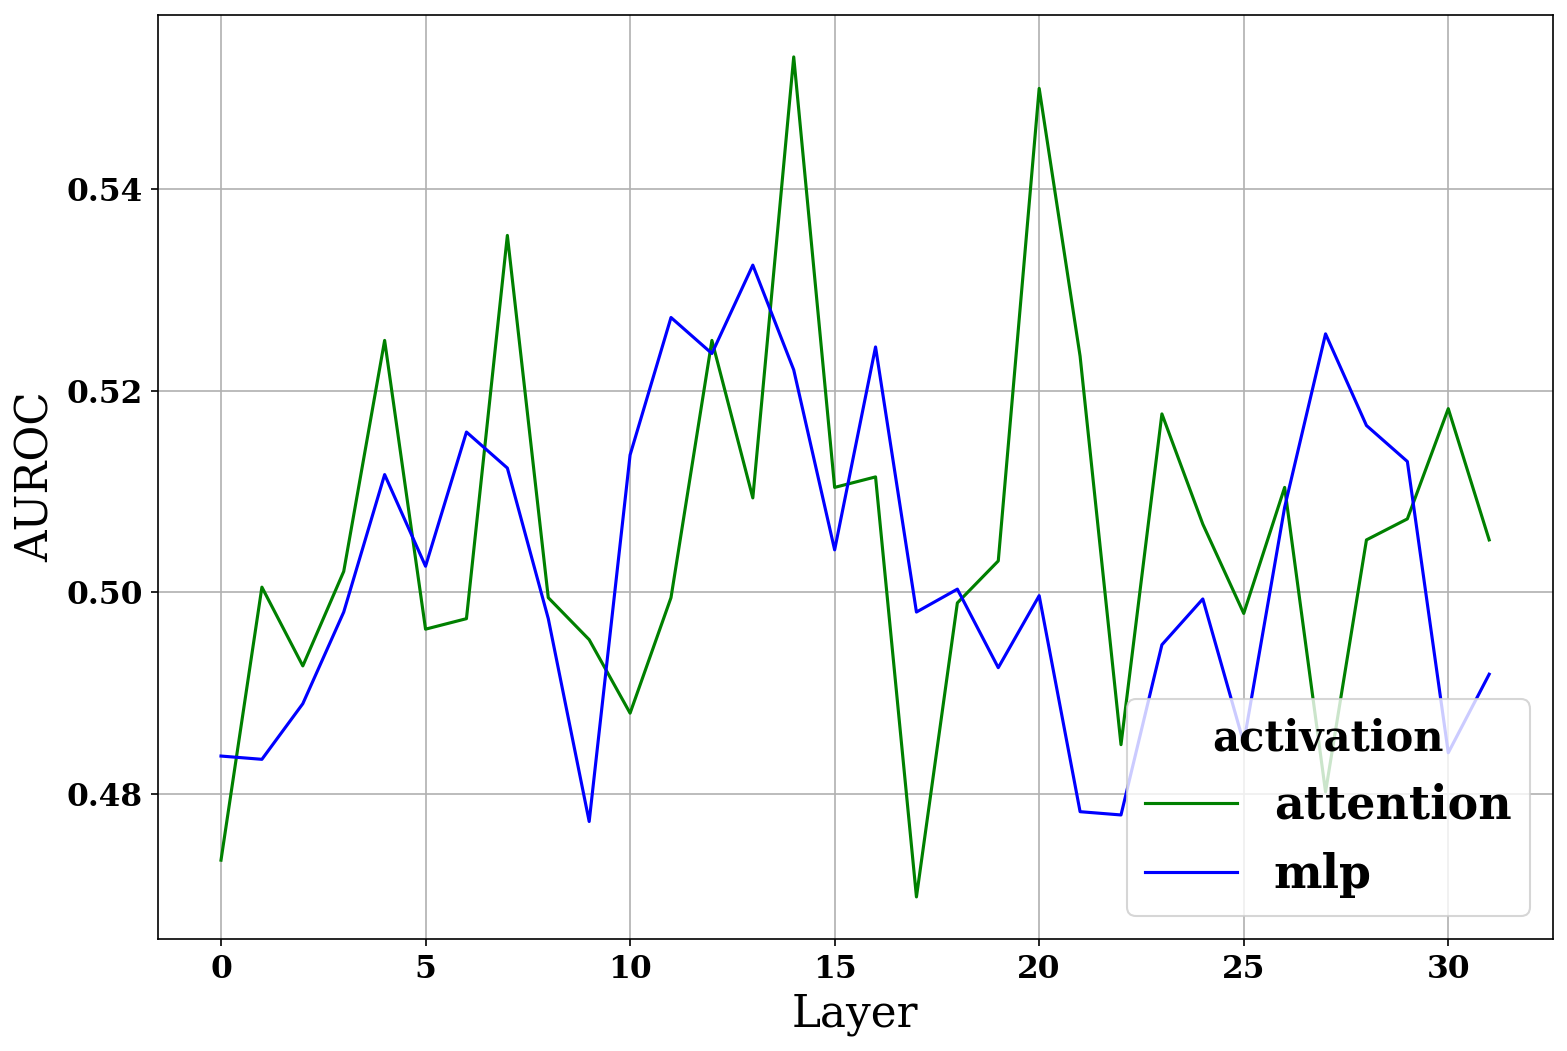

In [8]:
plot_model_accuracy(kc_df, "images", "falcon-7b", "nqswap")